# Single DK rumour spreading model


This model uses [graph-tool](https://graph-tool.skewed.de/) to efficiently support graph drawing at scale (~4000 nodes). [Unfortunately, graph tool does not support being installed through pip.](https://graph-tool.skewed.de/installation.html#native-installation)

To run this model, use the following instructions:
1. Install your python environment manager. If you don't have one, we recommend installing micromamba.
2. Set up your environment by running `micromamba env create --name compmodelling-dk -c conda-forge networkx graph-tool ipykernel`. If using conda or mamba, swap out 'micromamba' for the respective environment manager name.
3. Make sure your software reading this .ipynb file is using your compmodelling-dk python version. (Hint: use `which python` while in your environment to see where your python version is located). You may need to reload during this step for your software to recognise the environment.
4. When you're finished with your environment, remove it by running `micromamba env remove compmodelling-dk`.

In [2]:
import networkx as nx
from graph_tool.all import Graph, graph_draw, sfdp_layout, closeness
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from typing import Self
from IPython.display import clear_output

class State(Enum):
    SPREADER = 0 # People actively spreading the rumour
    IGNORANT = 1 # People who haven't encountered the rumour
    STIFLER = 2 # People who have heard the rumour but are not spreading it

STATUS_COLOURS = {
    State.SPREADER: 'red',
    State.IGNORANT: 'blue',
    State.STIFLER: 'green'
}

TIME_STEPS = 25
POPULATION_SIZE = 4039
CLUSTERING_COEFFICIENT = 44

ACTIVENESS = 0.1
RUMOUR_ACCEPTANCE_PROB = 0.2
SPREADER_SPREADER_STIFLE_PROB = 0.1
SPREADER_STIFLER_STIFLE_PROB = 0.1
FORGET_PROB = 0.01

In [3]:
class Person:
    def __init__(self: Self) -> None:
        self.state = State.IGNORANT
        self.contacted = []

    def spread_rumour(self: Self, neighbour: list) -> None:
        # Checks the nodes are active and haven't already contacted each other
        if neighbour in self.contacted:
            return
        if np.random.random() > ACTIVENESS:
            return

        # Add each other to the contacted list so they don't contact each other again this time step
        self.contacted.append(neighbour)
        neighbour.contacted.append(self)

        # If neighbour is ignorant
        if neighbour.state == State.IGNORANT:
            if np.random.random() < RUMOUR_ACCEPTANCE_PROB:
                neighbour.state = State.SPREADER
        # If neighbour is a spreader
        elif neighbour.state == State.SPREADER:
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                neighbour.state = State.STIFLER
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                self.state = State.STIFLER
        # If neighbour is a stifler
        elif neighbour.state == State.STIFLER:
            if np.random.random() < SPREADER_STIFLER_STIFLE_PROB:
                self.state = State.STIFLER

    def next(self: Self) -> None:
        if np.random.random() < FORGET_PROB:
            self.state = State.IGNORANT

        self.contacted = []

    def set_state(self: Self, state: State) -> None:
        self.state = state



In [8]:
def generate_barabasi_albert_graph(n: int, m: int) -> Graph:
    nx_graph = nx.barabasi_albert_graph(n, m)
    gt_graph = Graph(directed=False)
    gt_graph.add_edge_list(nx_graph.edges)
    return gt_graph

def generate_facebook_graph() -> Graph:
    nx_graph = nx.read_edgelist('datasets/facebook_combined.txt')
    gt_graph = Graph(directed=False)
    gt_graph.add_edge_list(nx_graph.edges)
    return gt_graph

In [5]:
class DKModel:
    def __init__(self: Self, graph: Graph, initial_rumour_spreaders: int) -> None:
        self.graph = graph
        self.colours = graph.new_vp("string")

        self.graph.vertex_properties['agent'] = self.graph.new_vertex_property('object')
        for vertex in self.graph.vertices():
            self.graph.vertex_properties['agent'][vertex] = Person()

        rumour_starters = np.random.choice(list(graph.vertices()), initial_rumour_spreaders, replace=False)
        for vertex in rumour_starters:
            self.graph.vertex_properties['agent'][vertex].set_state(State.SPREADER)

        # History tracking
        self.s_history = []
        self.i_history = []
        self.r_history = []

        # Cached graph drawing details
        self.pos = sfdp_layout(self.graph)
        self.vertex_order = closeness(self.graph)

    def step(self: Self) -> None:
        for vertex in self.graph.vertices():
            agent = self.graph.vertex_properties['agent'][vertex]

            for neighbour in self.graph.vertex(vertex).all_neighbours():
                if not agent.state == State.SPREADER:
                    break
                agent.spread_rumour(self.graph.vertex_properties['agent'][neighbour])

        # Count states
        spreaders, ignorants, stiflers = self.count_states()

        self.s_history.append(spreaders)
        self.i_history.append(ignorants)
        self.r_history.append(stiflers)

        for vertex in self.graph.vertices():
            agent = self.graph.vertex_properties['agent'][vertex]
            agent.next()

    def count_states(self: Self) -> tuple[int, int, int]:
        spreaders, ignorants, stiflers = 0, 0, 0
        for vertex in self.graph.vertices():
            agent = self.graph.vertex_properties['agent'][vertex]
            if agent.state == State.SPREADER:
                spreaders += 1
            elif agent.state == State.IGNORANT:
                ignorants += 1
            elif agent.state == State.STIFLER:
                stiflers += 1
        return spreaders, ignorants, stiflers

    def draw(self: Self) -> None:
        # Assemble colour map
        for vertex in self.graph.vertices():
            state = self.graph.vertex_properties['agent'][vertex].state
            self.colours[vertex] = STATUS_COLOURS[state]

        graph_draw(self.graph,
                   inline=True,
                   vertex_fill_color=self.colours,
                   pos=self.pos,
                   vertex_order=self.vertex_order)

    def run(self: Self, time_steps: int, draw=False) -> None:
        for _ in range(time_steps):
            if draw:
                self.draw()
            self.step()
            clear_output(wait=True)
        if draw:
            self.draw()

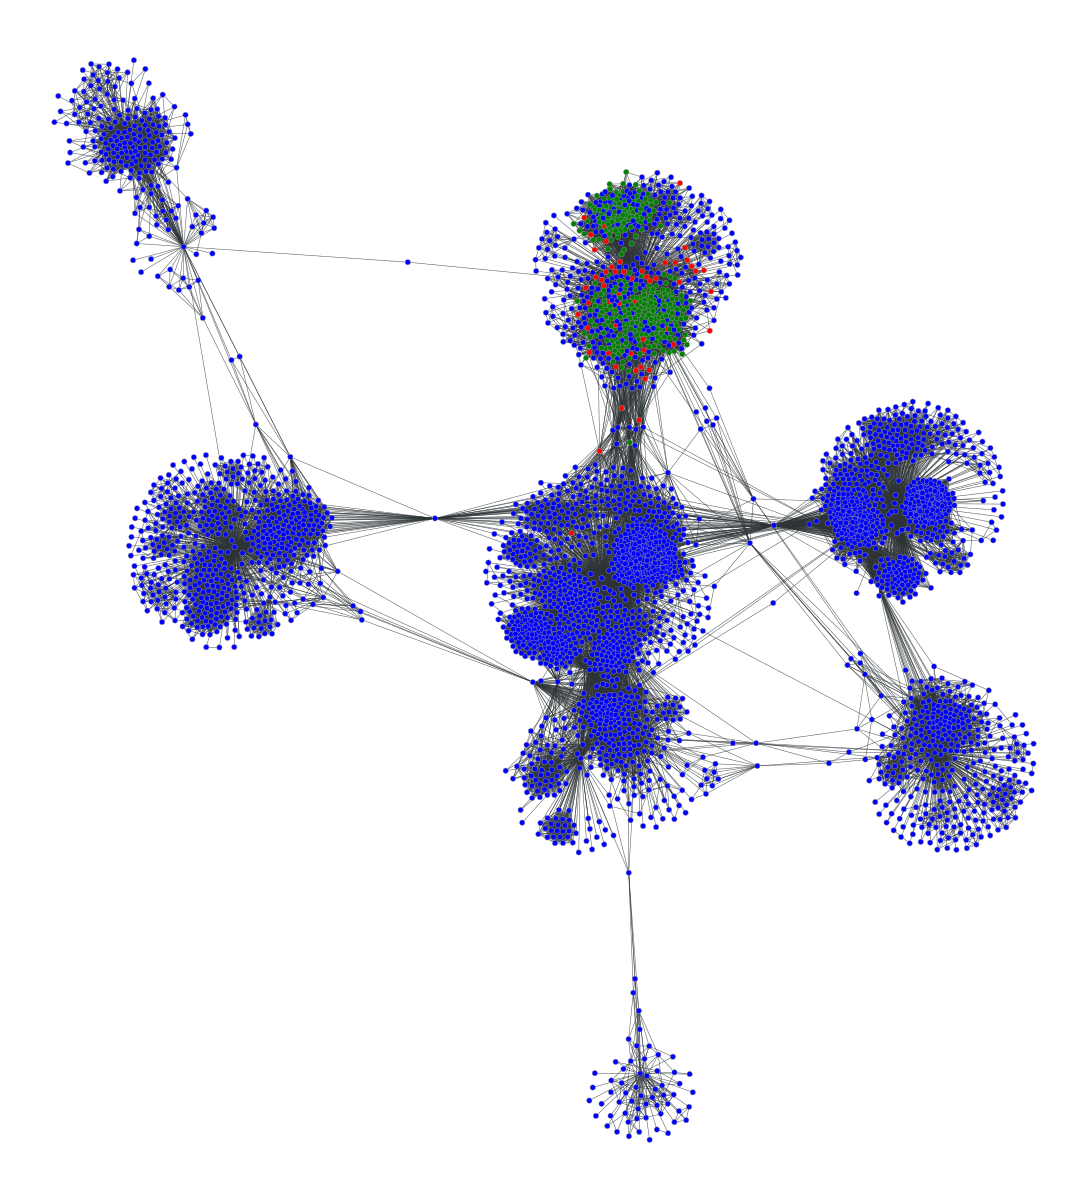

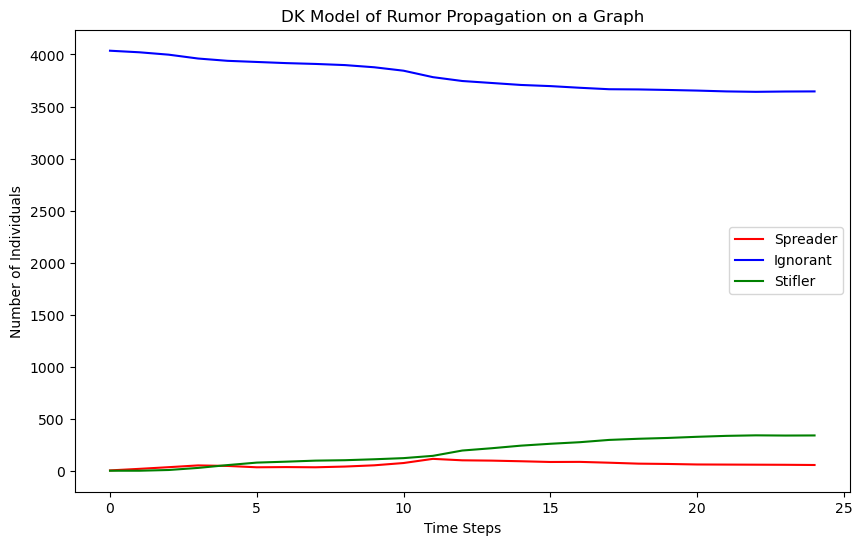

In [9]:
# graph = generate_barabasi_albert_graph(POPULATION_SIZE, CLIQUISHNESS)
graph = generate_facebook_graph()

dk_model = DKModel(graph, initial_rumour_spreaders=1)
dk_model.run(TIME_STEPS, draw=True)

plt.figure(figsize=(10, 6))
plt.plot(dk_model.s_history, label='Spreader', color=STATUS_COLOURS[State.SPREADER])
plt.plot(dk_model.i_history, label='Ignorant', color=STATUS_COLOURS[State.IGNORANT])
plt.plot(dk_model.r_history, label='Stifler', color=STATUS_COLOURS[State.STIFLER])
plt.title('DK Model of Rumor Propagation on a Graph')
plt.xlabel('Time Steps')
plt.ylabel('Number of Individuals')
plt.legend()
plt.show()

